In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from utilities import image_preprocess


from solvers import of_cg, of_vc, run_pcg
from image_gen import generate_test_image


## TMA4205 - Estimation of Optical Flow
##### Julie Rose Godal og Tor Løvold Haugen
----

#### Midlertidig innledning
Optical flow describes the apparent motion of image intensity over time and is used to estimate how points in an image move between two consecutive frames. In this project, the problem is modeled using the Horn–Schunck method, which assumes that the intensity of a point remains constant as it moves. This leads to a linear system of partial differential equations that can be solved numerically after discretization. The work focuses on formulating this system, analyzing its properties, and implementing different numerical approaches to compute the solution, including the Conjugate Gradient (CG) method, Gauss–Seidel smoothing, and a multigrid V–cycle.


#### Theory
The optical flow field $(u,v)$ between two consecutive grayscale frames $I_0$ and $I_1$ is modeled using the Horn–Schunck method. Assuming brightness constancy together with quadratic smoothness, leads to the energy functional
$$
E(u,v) = \int \big( (I_x u + I_y v + I_t)^2 + \lambda (\|\nabla u\|^2 + \|\nabla v\|^2) \big)\, dx\, dy,
$$
where $\lambda > 0$ controls the balance between data quality and smoothness. Minimizing this energy yields the coupled Euler–Lagrange equations
$$
(I_x^2)u + (I_x I_y)v - \lambda \Delta u = -I_x I_t, \qquad
(I_x I_y)u + (I_y^2)v - \lambda \Delta v = -I_y I_t,
$$
subject to Dirichlet boundary conditions $u = v = 0$ on the image boundary.

In the discrete setting, the image domain is represented on an $m \times n$ grid with unit spacing. The temporal derivative is given by $I_t = I_1 - I_0$, while the spatial derivatives $I_x$ and $I_y$ are computed using forward finite differences and averaged across the two frames.

We examine the linear system obtained after discretizing the Horn–Schunck optical flow equations. Understanding its general structure, coupling, and boundary behavior is essential before choosing suitable numerical methods. We will then discuss how these characteristics influence the stability and solvability of the numerical problem.

The discrete system of equations for each pixel $(i,j)$ can be written as

$$
\partial_x I_{ij}^2\, u_{ij} 
+ \partial_x I_{ij}\, \partial_y I_{ij}\, v_{ij}
- \lambda (A_h^0 u)_{ij}
= - (\partial_t I)_{ij} (\partial_x I)_{ij},
$$

$$
\partial_y I_{ij}^2\, v_{ij}
+ \partial_y I_{ij}\, \partial_x I_{ij}\, u_{ij}
- \lambda (A_h^0 v)_{ij}
= - (\partial_t I)_{ij} (\partial_y I)_{ij}.
$$

These equations represent two coupled linear relations between the horizontal and vertical flow components, where the terms involving spatial derivatives of the image couple $u$ and $v$, and the Laplacian term enforces smoothness through the regularization parameter $\lambda$.

We define the spatial and temporal derivatives for simplicity as

$$
I_x := \partial_x I, \qquad
I_y := \partial_y I, \qquad
I_t := \partial_t I.
$$

Substituting these into the equations gives the form

$$
I_x^2 u + I_x I_y v - \lambda A_h^0 u = - I_t I_x,
$$

$$
I_y^2 v + I_x I_y u - \lambda A_h^0 v = - I_t I_y.
$$

Here, $A_h^0$ denotes the discrete Laplacian operator acting on the interior of the image domain.

To express this system in matrix form, we introduce diagonal matrices containing the image-dependent coefficients:

$$
D_{xx} = \mathrm{diag}(I_x^2), \qquad
D_{yy} = \mathrm{diag}(I_y^2), \qquad
D_{xy} = \mathrm{diag}(I_x I_y).
$$

This yields the full coupled system

$$
\begin{bmatrix}
D_{xx} - \lambda A_h^0 & D_{xy} \\
D_{xy} & D_{yy} - \lambda A_h^0
\end{bmatrix}
\begin{bmatrix}
U \\[2pt] V
\end{bmatrix}
=
\begin{bmatrix}
D_{xt} \\[2pt] D_{yt}
\end{bmatrix}.
$$

The structure of this matrix shows that the system couples $u$ and $v$ symmetrically through the off-diagonal blocks $D_{xy}$, while the diagonal blocks contain both the image gradient terms and the regularization operator. Thus, the coefficient matrix $A$ is symmetric and, for $\lambda > 0$, positive definite on the interior domain.

To analyze the definiteness of the system matrix, we split it into two parts. A diagonal part that depends on the image derivatives, and a Laplacian part that represents the regularization. This shows how each term contributes to the overall stability of the system.

We write the matrix as

$$
A =
\begin{bmatrix}
D_{xx} & D_{xy} \\
D_{xy} & D_{yy}
\end{bmatrix}
-
\begin{bmatrix}
\lambda A_h^0 & 0 \\
0 & \lambda A_h^0
\end{bmatrix}.
$$

The second term contains the discrete Laplacian $A_h^0$ with Dirichlet boundary conditions. It is known that the negative Laplacian under these conditions is symmetric positive definite (SPD), meaning that it contributes positively to the energy and stabilizes the system through smoothing.

Next, we analyze the diagonal part $D$, which depends on the image gradients. Let $x_1, x_2 \in \mathbb{R}$ represent arbitrary scalar coefficients, then

$$
x^T D x
=
\begin{bmatrix} x_1 & x_2 \end{bmatrix}
\begin{bmatrix}
D_{xx} & D_{xy} \\
D_{xy} & D_{yy}
\end{bmatrix}
\begin{bmatrix} x_1 \\ x_2 \end{bmatrix}
=
x_1^2 D_{xx} + 2x_1 x_2 D_{xy} + x_2^2 D_{yy}.
$$

This expression represents the local quadratic form associated with the data term at each pixel. Since the matrices $D_{xx}$, $D_{yy}$, and $D_{xy}$ are diagonal, the computation can be written element-wise as

$$
x^T D x = \sum_i (x_1 I_{x,i} + x_2 I_{y,i})^2 > 0.
$$

Each term in the sum is nonnegative and only vanishes if both $I_{x,i}$ and $I_{y,i}$ are zero simultaneously. Therefore, $D$ must be at least symmetric semi-positive definite.

Since the Laplacian part is SPD and the diagonal part is semi-positive definite, their sum must be SPD for $\lambda > 0$. This means that the full system matrix $A$ is symmetric positive definite, ensuring that the optical flow equations admit a unique and stable solution.

To investigate the diagonal dominance of the system matrix, we analyze the relative size of the diagonal and off-diagonal elements in each block. 

We start by writing the matrix as

$$
A =
\begin{bmatrix}
D_{xx} - \lambda A_h^0 & D_{xy} \\
D_{xy} & D_{yy} - \lambda A_h^0
\end{bmatrix}.
$$

Here, $D_{xx}$ and $D_{yy}$ are diagonal matrices containing image-gradient terms, while $A_h^0$ is the discrete Laplacian. The Laplacian contributes positive diagonal entries $d_i > 0$ and negative off-diagonal entries $-1$ corresponding to neighboring pixels.

For the $u$-component, the diagonal entry at pixel $i$ is

$$
a_{ii} = I_x[i]^2 + \lambda d_i,
$$

while the off-diagonal entries come from the Laplacian and the coupling to $v$. Neighboring pixels: $a_{ij} = -\lambda$ for $j \in \mathcal{N}(i)$. Cross-block coupling: $a_{i, N+i} = I_x[i] I_y[i]$

Diagonal dominance requires that the magnitude of the diagonal entry is greater than or equal to the sum of the magnitudes of the off-diagonal entries:

$$
|a_{ii}| \ge \sum_{j\neq i} |a_{ij}|.
$$

Substituting the expressions gives

$$
I_x[i]^2 + \lambda d_i \ge \lambda d_i + |I_x[i] I_y[i]|.
$$

After canceling the regularization terms, this simplifies to

$$
I_x[i]^2 \ge |I_x[i] I_y[i]|.
$$

Applying the same reasoning to the $v$-component gives

$$
I_y[i]^2 \ge |I_x[i] I_y[i]|.
$$

The conditions for diagonal dominance in both blocks are therefore

$$
|I_x[i]| \ge |I_y[i]|, \qquad |I_y[i]| \ge |I_x[i]|.
$$

These two inequalities can only hold simultaneously if

$$
|I_x[i]| = |I_y[i]|.
$$

This means that strict diagonal dominance occurs only in special cases where the horizontal and vertical image gradients have equal magnitude at every pixel. Hence global diagonal dominance of \(A\) cannot be guaranteed.

In summary, the discretized optical flow system forms a large, sparse, symmetric linear system whose properties are determined by the local image derivatives and the chosen regularization.By separating the operator into a data-dependent diagonal part and a regularization-based Laplacian part, we see that both components combined are SPD. Consequently, the full system matrix $A$ is symmetric positive definite. While the diagonal and Laplacian contributions stabilize the system, the presence of cross-coupling terms $I_x I_y$ prevents strict diagonal dominance in most cases. 

The lack of global diagonal dominance implies that the Jacobi and Gauss–Seidel methods are not guaranteed to converge for this system, since their convergence typically relies on the diagonal elements dominating the off-diagonal ones. This is because the convergence of these methods rely on the spectral radius of their itereation matrix. And they only converge if the spectral radius, $\rho$, is less than one, which can only be guaranteed by strict diagonal dominence. In practice, these methods may still work for some images but can converge slowly or even diverge depending on the local image gradients and coupling strength.

In contrast, the Conjugate Gradient (CG) method only requires the coefficient matrix to be symmetric positive definite, which we have shown to hold for this system. Therefore, CG is both theoretically guaranteed to converge and generally much more efficient for solving the discretized Horn–Schunck equations.

#### Implementation of Numerical Methods
From the previous section, it is known that this system operator is symmetric and positive definite, but not globally diagonally dominant. Therefore, the linear system $A(u,v)=b$ is most efficiently solved with the Conjugate Gradient (CG) method. 

The CG method iteratively minimizes the quadratic energy associated with the system matrix by updating the solution along mutually conjugate search directions. In each iteration, a step length is computed to minimize the residual in the current direction, and a new search direction is formed as a combination of the current residual and the previous direction. This ensures that convergence occurs in at most as many steps as the number of unknowns.

When implementing this method, a five-point Laplacian is applied only on the strict interior. All inner products and updates are restricted to interior indices, while the border remains clamped to zero. Thus, boundary pixels are excluded from all linear algebra and kept at zero, which enforces the dirichlet condition.

Convergence is declared when the relative residual
$$
\frac{\|r_k\|_2}{\|r_0\|_2} < \texttt{tol}, \qquad
\|r_k\|_2^2 = \langle r_u,r_u\rangle + \langle r_v,r_v\rangle,
$$
drops below the prescribed tolerance. This applies to all future implementations as well.


#### Task 3 — Multigrid V–Cycle for Optical Flow

To improve the efficiency of solving the Horn–Schunck optical flow equations, a **multigrid V–cycle** is used. The discrete system solved on the interior can be written as
$$
A(u, v) = [ [Ix², IxIy], [IxIy, Iy²] ] [u, v]^T - λ[Δu, Δv]^T = [-IxIt, -IyIt]^T,
$$
where λ is the regularization parameter and u = v = 0 on the boundary. The multigrid approach combines local smoothing and coarse-grid correction to remove errors at all spatial frequencies more efficiently than a single grid method.

The smoother applies a red–black Gauss–Seidel iteration that updates interior pixels alternately by solving a small coupled 2×2 system for each pixel. This reduces high-frequency errors in both u and v while keeping the boundary fixed at zero. After a few pre-smoothing sweeps, the residual r = b − A(u, v) is computed and transferred to a coarser grid using restriction. Restriction is done with full-weighting, averaging neighboring values with weights [1/4, 1/2, 1/4] in both directions. The image derivatives Ix and Iy are restricted in the same way to preserve the structure of the operator.

On the coarse grid, the error equation is solved approximately, either by recursion to the next coarser level or, at the coarsest grid, by a small number of Conjugate Gradient iterations. The resulting coarse-grid error is interpolated back to the fine grid through prolongation using bilinear interpolation, and the fine-grid solution is corrected by adding this interpolated error. A few post-smoothing sweeps are then applied to remove the remaining high-frequency errors.

Each V–cycle therefore performs pre-smoothing, residual computation, restriction, coarse solve, prolongation, and post-smoothing. This hierarchy of grids efficiently removes both low- and high-frequency components of the error, producing grid-independent convergence for the coupled optical flow equations while maintaining Dirichlet boundaries and the coupling between u and v through the image derivatives.


oppgave 4

#### Numerical tests
In order to evaluate the methods implemented in the previous section, numerical experiments will be preformed on each method. These tests will use the second testcase implemented in generate_test_images using the supplemented code from the course. This function produces $(N \times N)$ images of two Gaussians circling each other. The methods will be compared when solving images of size $2^k \times 2^k$ for $k = 6,\dots,9$. The regularisation parameter will be given by $\lambda^k = 4^{k−4}$, where $k$ depends on the image size, for these tests.

##### Temp skrevet bare så jeg ikke glemmer det
Additionally, we will test the different methods using the images frame10.png and frame11.png from the webpage of the course.

In [10]:
tol = 1e-8
maxit = 2000

test_results = np.zeros((3,5,3)) # method, image size, (iterations, time, size)
residual_history_cg = [[],[],[],[],[]]
residual_history_vc = [[],[],[],[],[]]

for i in range(6, 11):
    N = 2**i
    lam = 4**(i-4)

    Im_0, Im_1 = generate_test_image(N, testcase=2)
    u0, v0, Ix, Iy, rhsu, rhsv, I0, I1 = image_preprocess(Im_0, Im_1)
    
    start_time = time.time()
    u_cg, v_cg, it_cg, rel_cg, residual_history_cg[i-6] = of_cg(u0, v0, Ix, Iy, lam, rhsu, rhsv, tol=tol, maxit=maxit)
    end_time = time.time() - start_time
    test_results[0,i-6,:] = [it_cg, end_time, N]

    start_time = time.time()
    u_vc, v_vc, it_vc, rel_vc, residual_history_vc[i-6] = of_vc(u0, v0, Ix, Iy, lam, rhsu, rhsv, tol=tol, maxit=maxit)
    end_time = time.time() - start_time
    test_results[1,i-6,:] = [it_vc, end_time, N]

    print(f"Image size: {N}x{N}, λ={lam} => CG: iterations={it_cg}, time={test_results[0,i-6,1]:.3}, final rel_res^2={rel_cg:.3e} | VC: iterations={it_vc}, time={test_results[1,i-6,1]:.3}, final rel_res^2={rel_vc:.3e}")

rhu sise before restriction(65, 65)
rhu before restriction, [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.59524592e-18 -2.40741243e-34 ...  4.13590306e-25
   1.40161726e-08  0.00000000e+00]
 [ 0.00000000e+00  1.80555932e-34 -3.44421874e-17 ...  1.28526839e-07
  -3.30872245e-24  0.00000000e+00]
 ...
 [ 0.00000000e+00  1.37753244e-39 -1.92864311e-22 ... -4.15258164e-09
  -1.55096365e-25  0.00000000e+00]
 [ 0.00000000e+00 -6.15353117e-24  1.19386145e-39 ...  7.75481824e-26
  -4.62154415e-10  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
rhu after restriction, [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -5.20984158e-17 -1.42164715e-15 ...  6.95033194e-07
   1.09350760e-07  0.00000000e+00]
 [ 0.00000000e+00 -4.94871037e-16 -1.34465767e-14 ...  5.61100091e-06
 

In [ ]:
# tol = 1e-8
# maxit = 2000

# test_results = np.zeros((3,1,3))     # only 1 image now
# residual_history_cg = [[]]
# residual_history_vc = [[]]

# # ---- choose the single image size ----
# i = 6         # choose 6..10, or any you want
# N = 2**i
# lam = 4**(i-4)

# # --------------------------------------
# Im_0, Im_1 = generate_test_image(N, testcase=2)
# u0, v0, Ix, Iy, rhsu, rhsv, I0, I1 = image_preprocess(Im_0, Im_1)

# # start_time = time.time()
# # u_cg, v_cg, it_cg, rel_cg, residual_history_cg[0] = of_cg(
# #     u0, v0, Ix, Iy, lam, rhsu, rhsv, tol=tol, maxit=maxit)
# # test_results[0,0,:] = [it_cg, time.time() - start_time, N]

# start_time = time.time()
# u_vc, v_vc, it_vc, rel_vc, residual_history_vc[0] = of_vc(
#     u0, v0, Ix, Iy, lam, rhsu, rhsv, tol=tol, maxit=maxit)
# test_results[1,0,:] = [it_vc, time.time() - start_time, N]

# # print(f"Image size: {N}x{N}, λ={lam} => "
# #       f"CG: iter={it_cg}, time={test_results[0,0,1]}, rel_res²={rel_cg} | ")
# print(f"Image size: {N}x{N}, λ={lam} => "
#       f"VC: iter={it_vc}, time={test_results[1,0,1]}, rel_res²={rel_vc}")



rhu sise before restriction(65, 65)
rhu before restriction, [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.59524592e-18 -2.40741243e-34 ...  4.13590306e-25
   1.40161726e-08  0.00000000e+00]
 [ 0.00000000e+00  1.80555932e-34 -3.44421874e-17 ...  1.28526839e-07
  -3.30872245e-24  0.00000000e+00]
 ...
 [ 0.00000000e+00  1.37753244e-39 -1.92864311e-22 ... -4.15258164e-09
  -1.55096365e-25  0.00000000e+00]
 [ 0.00000000e+00 -6.15353117e-24  1.19386145e-39 ...  7.75481824e-26
  -4.62154415e-10  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
rhu after restriction, [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -5.20984158e-17 -1.42164715e-15 ...  6.95033194e-07
   1.09350760e-07  0.00000000e+00]
 [ 0.00000000e+00 -4.94871037e-16 -1.34465767e-14 ...  5.61100091e-06
 

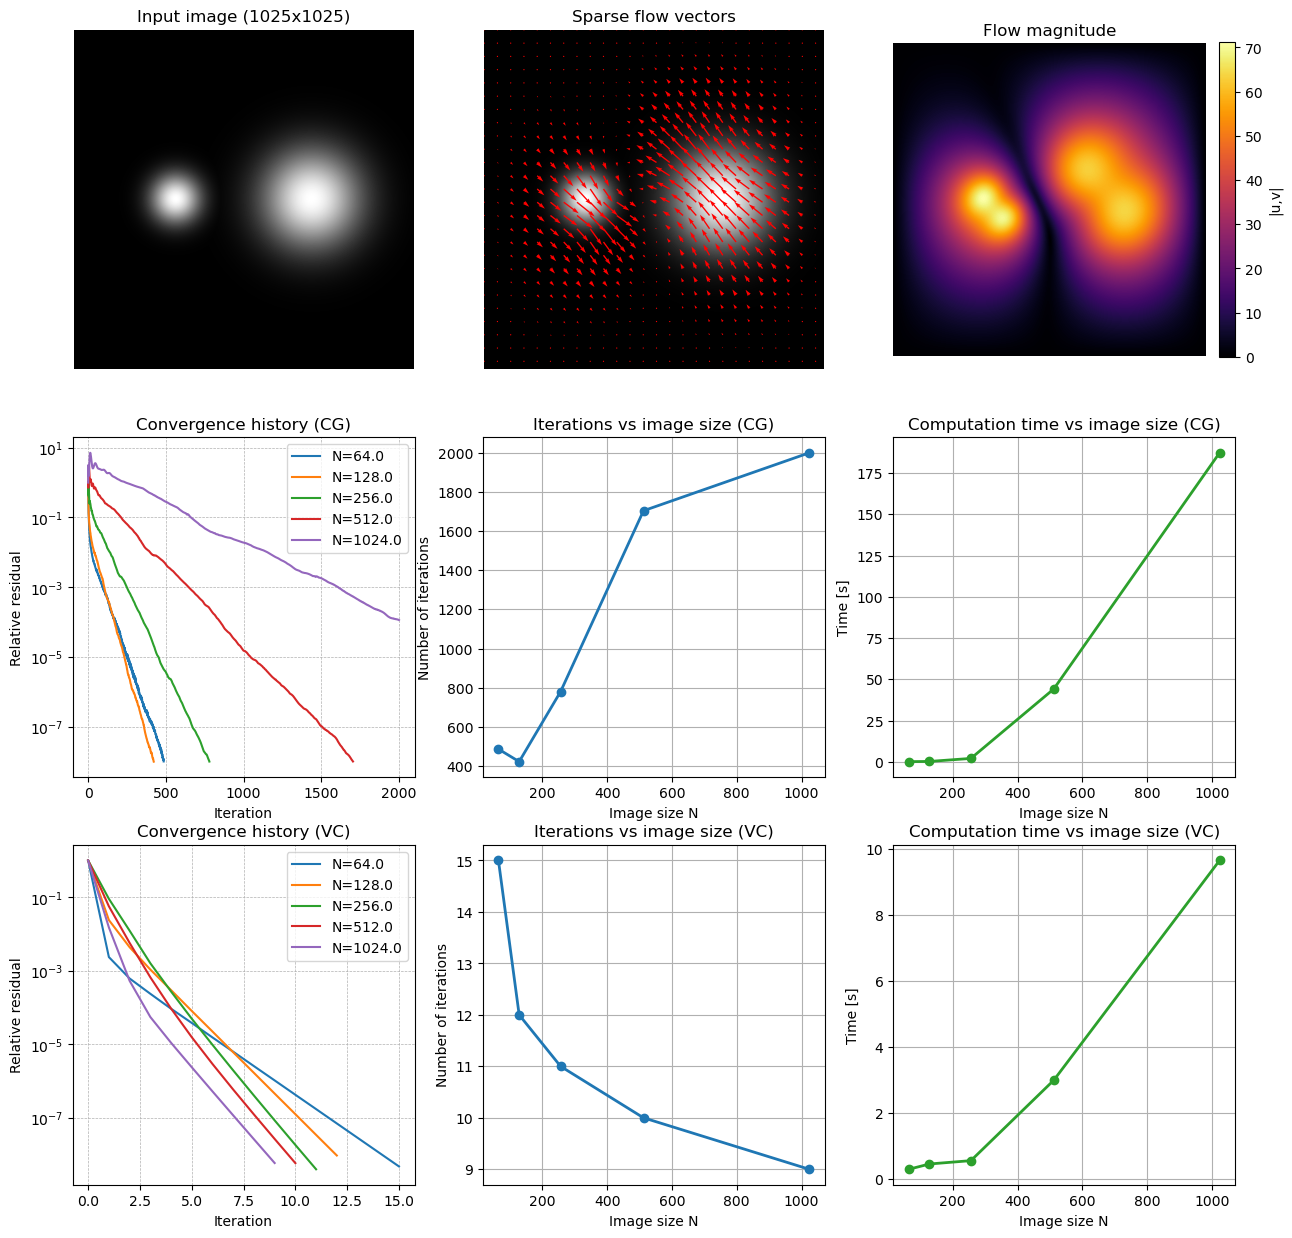

Test results (rows: CG, VC; columns: iterations, time [s], image size N):
[[[4.86000000e+02 1.19688511e-01 6.40000000e+01]
  [4.22000000e+02 2.35303402e-01 1.28000000e+02]
  [7.80000000e+02 2.07170296e+00 2.56000000e+02]
  [1.70400000e+03 4.41794615e+01 5.12000000e+02]
  [2.00000000e+03 1.87326124e+02 1.02400000e+03]]

 [[1.50000000e+01 3.00075531e-01 6.40000000e+01]
  [1.20000000e+01 4.60515499e-01 1.28000000e+02]
  [1.10000000e+01 5.62099218e-01 2.56000000e+02]
  [1.00000000e+01 2.99820733e+00 5.12000000e+02]
  [9.00000000e+00 9.65440154e+00 1.02400000e+03]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]]]


In [11]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

flow_mag = np.sqrt(u_cg**2 + v_cg**2)
step = 40  # spacing for quiver arrows
Y, X = np.mgrid[0:u_cg.shape[0], 0:u_cg.shape[1]]
mask = (X % step == 0) & (Y % step == 0)

# Original grayscale image
axes[0,0].imshow(I0, cmap="gray")
axes[0,0].set_title(f"Input image ({u_cg.shape[0]}x{u_cg.shape[1]})")
axes[0,0].axis("off")

#  Quiver overlay
axes[0,1].imshow(I0, cmap="gray")
axes[0,1].quiver(X[mask], Y[mask], u_cg[mask], v_cg[mask], color="red", angles="xy", scale_units="xy", scale=1.0, width=0.004)
axes[0,1].set_title("Sparse flow vectors")
axes[0,1].axis("off")

# Flow magnitude
im = axes[0,2].imshow(flow_mag, cmap="inferno")
axes[0,2].set_title("Flow magnitude")
axes[0,2].axis("off")
fig.colorbar(im, ax=axes[0,2], fraction=0.046, pad=0.04, label="|u,v|")

#CG
# Convergence history (residual vs iteration)
for N, res in zip(test_results[0,:,2], residual_history_cg):
    axes[1,0].semilogy(res, label=f"N={N}")

axes[1,0].set_title("Convergence history (CG)")
axes[1,0].set_xlabel("Iteration")
axes[1,0].set_ylabel("Relative residual")
axes[1,0].legend()
axes[1,0].grid(True, which="both", ls="--", lw=0.5)

# Iterations vs image size
axes[1,1].plot(test_results[0,:,2], test_results[0,:,0], "o-", color="tab:blue", lw=2)
axes[1,1].set_title("Iterations vs image size (CG)")
axes[1,1].set_xlabel("Image size N")
axes[1,1].set_ylabel("Number of iterations")
axes[1,1].grid(True)

# Computation time vs image size
axes[1,2].plot(test_results[0,:,2], test_results[0,:,1], "o-", color="tab:green", lw=2)
axes[1,2].set_title("Computation time vs image size (CG)")
axes[1,2].set_xlabel("Image size N")
axes[1,2].set_ylabel("Time [s]")
axes[1,2].grid(True)

# VC
# Convergence history (residual vs iteration)
for N, res in zip(test_results[1,:,2], residual_history_vc):
    axes[2,0].semilogy(res, label=f"N={N}")

axes[2,0].set_title("Convergence history (VC)")
axes[2,0].set_xlabel("Iteration")
axes[2,0].set_ylabel("Relative residual")
axes[2,0].legend()
axes[2,0].grid(True, which="both", ls="--", lw=0.5)

# Iterations vs image size
axes[2,1].plot(test_results[1,:,2], test_results[1,:,0], "o-", color="tab:blue", lw=2)
axes[2,1].set_title("Iterations vs image size (VC)")
axes[2,1].set_xlabel("Image size N")
axes[2,1].set_ylabel("Number of iterations")
axes[2,1].grid(True)

# Computation time vs image size
axes[2,2].plot(test_results[1,:,2], test_results[1,:,1], "o-", color="tab:green", lw=2)
axes[2,2].set_title("Computation time vs image size (VC)")
axes[2,2].set_xlabel("Image size N")
axes[2,2].set_ylabel("Time [s]")
axes[2,2].grid(True)

plt.show()

print("Test results (rows: CG, VC; columns: iterations, time [s], image size N):")
print(test_results)


In [ ]:
frame0_path = "test_images/frame10.png"
frame1_path = "test_images/frame11.png"
Im_0 = plt.imread(frame0_path)
Im_1 = plt.imread(frame1_path)